### Load the Commit Statistics
For this clustering we examined 39 GitHub projects containing a total of 2,629 commits. The projects all included the Fluence Marine library. Code for Fluence is generally written in React and Rust.

In [1]:
project_root_path = '../../..'
lib_path = project_root_path + "/jupyter/lib/"

import json
import sys

sys.path.append(lib_path)
import commit_stat_engineering

dataset_dir = project_root_path + '/data/github/2022-04-07-marine-search'
project_stats_dir = dataset_dir + '/projects'
all_commit_logs = commit_stat_engineering.find_files('commit-stat.log.json', project_stats_dir)
all_stats = commit_stat_engineering.get_stats_for_all_commits(all_commit_logs)

### Select The Features
This clustering is for data analysis, not production. I am intentionally excluding the aggregate statistics - binFiles, textFiles, and textLines - from the list of input features. This prevents the ML model from taking a short-cut with those potentially over-powered statistics. My goal here is to see how effective the finer-grained statistics are.

I also tested with binFiles, textFiles, and textLines included. The results are nearly identical and not sufficiently illuminating to warrant inclusion here.

In [2]:
import numpy as np

X = [[np.log1p(stat['javascriptLines']),
      np.log1p(stat['rustLines']),
      np.log1p(stat['markdownLines']),
      np.log1p(stat['jsonLines']),
      np.log1p(stat['imgFiles']),
      np.log1p(stat['lockLines']),
      np.log1p(stat['yarnLines']),
      np.log1p(stat['clojureLines']),
      np.log1p(stat['htmlLines']),] for stat in all_stats]

### Clustering with Eight Centers
Exploring various numbers of centers, eight gives us a good impression of the quality of information we are getting from this feature set.

In [3]:
from sklearn.cluster import KMeans

num_clusters = 8
random = 0

y_pred = KMeans(n_clusters=num_clusters, random_state=random).fit_predict(X)

### Histogram of Cluster Sizes
Looking at a histogram of cluster sizes can show if there are major anomolies. In this case we have a reasonable distribution of cluster sizes. 

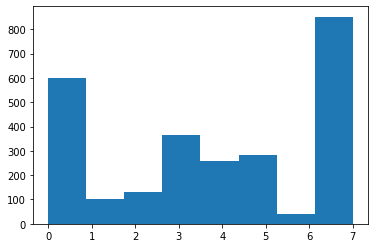

In [4]:
import matplotlib.pyplot as plt

plt.hist(y_pred, num_clusters)
plt.show()

### Reshape the Stats for Easier Handling

In [5]:
for i in range(0, len(y_pred)):
    all_stats[i]['cluster'] = y_pred[i]
    
clusters = [i for i in range(0, num_clusters)]
for i in range(0, num_clusters):
    clusters[i] = [stats for stats in all_stats if stats['cluster'] == i]

### Show Median Statistics for Each Cluster
The table generated here has median values for each cluster to facilitate interpetation of the data. The output fields shown were not included directly as input features, though they are dependent variables.

In [6]:
import numpy as np
import pandas as pd

cluster_names = ['#' + str(i) for i in range(0,len(clusters))]
fields = ['numCommits', 'binFiles', 'textFiles', 'textLines',
          'javascriptLinePct', 'rustLinePct', 'markdownLinePct', 'jsonLinePct',
          'imgFilePct', 'lockLinePct', 'yarnLinePct', 'htmlLinePct']

for cluster in clusters:
    numCommits = len(cluster)
    for stats in cluster:
        stats['numCommits'] = numCommits

data = [[int(np.round(np.median([stats[field] for stats in cluster]))) for field in fields] for cluster in clusters]
cluster_df = pd.DataFrame(data, index=cluster_names, columns=fields)
cluster_df.transpose()

,#0,#1,#2,#3,#4,#5,#6,#7
numCommits,601,101,131,364,258,282,40,852
binFiles,0,0,0,0,0,0,3,0
textFiles,4,1,8,10,1,2,48,1
textLines,62,41,4920,312,26,88,30194,4
javascriptLinePct,0,0,2,0,0,100,2,0
rustLinePct,100,0,0,38,0,0,0,0
markdownLinePct,0,0,0,0,100,0,0,0
jsonLinePct,0,0,97,0,0,0,80,0
imgFilePct,0,0,0,0,0,0,4,0
lockLinePct,0,0,0,54,0,0,4,0


### Interpreting the Clusters
Each datapoint above is a median value of the commits in the cluster.
#### Cluster #0: Rust Development Commits
62 lines of Rust code shows these are standard Rust developer commits.
#### Cluster #1: HTML Commits
41 lines of HTML (including CSS) mark these as web interface commits.
#### Cluster #2: Big JSON Commits
4,920 lines JSON means these are not hand-coded. Feature analysis showed a bimodal distribution which may be related. Further investigation will be needed.
#### Cluster #3: Rust Packaging Commits
A bit more Rust than in a Rust Development Commit plus some "lock" lines. ".lock" files are associated with the Rust package manager, Cargo.
#### Cluster #4: Documentation Commits
26 lines of markdown identifies these documentation commits.
#### Cluster #5: Javascript Development Commits
88 lines of Javascript shows these are standard JS developer commits.
#### Cluster #6: Bulk Commits
These large commits include both text and binary data. These commits might include platform code, template code, or unpacked 3rd party toolkits.
#### Cluster #7: Bugfixes & Tweaks
Small commits that address a single problem. Could be code or documentation. Median values in this chart hide the specific type - the code type will be retained in the final pipeline.

